In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('D:\weibo_date\date_2w.csv', encoding='gb18030')

In [3]:
df.shape

(20000, 2)

In [4]:
x = df[['comment']]
y = df.sentiment

In [5]:
import jieba
def word_cut(text):
    return " ".join(jieba.cut(text))

In [6]:
x['cutted_comment'] = x.comment.apply(word_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIUDAS~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.341 seconds.
Prefix dict has been built succesfully.


In [7]:
x.cutted_comment[:5]

0    更博 了 ， 爆照 了 ， 帅 的 呀 ， 就是 越来越 爱 你 ！ 生快 傻 缺 [ 爱 ...
1    @ 张晓鹏 jonathan   土耳其 的 事要 认真对待 [ 哈哈 ] ， 否则 直接 ...
2    姑娘 都 羡慕 你 呢 … 还有 招财猫 高兴 … … / / @ 爱 在 蔓延 - JC ...
3                                  美 ~ ~ ~ ~ ~ [ 爱 你 ]
4                       梦想 有 多 大 ， 舞台 就 有 多 大 ! [ 鼓掌 ]
Name: cutted_comment, dtype: object

In [8]:
#加载停用词表
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file) as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

In [9]:
stop_words_file = "stopwordsHIT.txt"
stopwords = get_custom_stopwords(stop_words_file)

In [10]:
#   采用TfidfVectorizer提取文本特征向量
from sklearn.feature_extraction.text import  TfidfVectorizer
tfid_vec = TfidfVectorizer(max_df = 0.8,
                       min_df = 3,
                       token_pattern=u'[\u4e00-\u9fa5]+',#u'(?u)\\b[^\\d\\W]\\w+\\b',
                       #stop_words=frozenset(stopwords),
                       ngram_range=(1,1))

In [11]:
#加载朴素贝叶斯分类器
from sklearn.naive_bayes import MultinomialNB
nb1 = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb2 = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

In [12]:
from sklearn.pipeline import make_pipeline

In [14]:
pipe1 = make_pipeline(tfid_vec, nb1)
pipe2 = make_pipeline(tfid_vec, nb2)

In [15]:
from sklearn.model_selection import cross_val_score #加载交叉验证工具

In [16]:
import matplotlib.pyplot as plt#加载可视化绘图工具

In [17]:
k_range = range(11,21)
cv_scores = [] #用来放每个模型的结果值

In [18]:
from sklearn.model_selection import train_test_split
for n in k_range:
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=n, shuffle=True)
    scores = cross_val_score(pipe1, x_train.cutted_comment, y_train, cv=5, scoring='accuracy')  #cv：选择每次测试折数  accuracy：评价指标是准确度,可以省略使用默认值
    cv_scores.append(scores.mean())

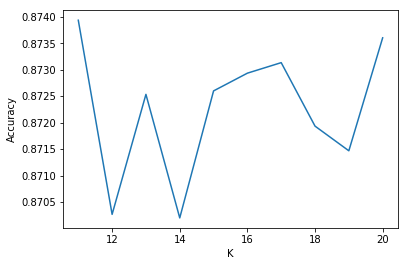

In [19]:
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')		#通过图像选择最好的参数
plt.show()

In [20]:
cv_scores

[0.8739332166740612,
 0.8702664107629345,
 0.8725330387629302,
 0.8701992107184309,
 0.8725984610294587,
 0.8729334333259372,
 0.8731323940887845,
 0.8719333888814876,
 0.8714672165111722,
 0.8736010166815944]

In [23]:
#选择最优的模型参数
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=11, shuffle=True)
cv_best = cross_val_score(pipe2, x_train.cutted_comment, y_train, cv=5, scoring='accuracy')
pipe2.fit(x_train.cutted_comment, y_train)#训练
x_tfid_test = tfid_vec.transform(x_test.cutted_comment)#测试集向量化
nb2_predict = nb2.predict(x_tfid_test)#保存预测结果

In [24]:
cv_best

array([0.87604132, 0.873     , 0.87666667, 0.86966667, 0.87429143])

In [25]:
scores_best = []
scores_best.append(cv_best.mean())

In [26]:
print("TfidfVectorizer提取的特征学习模型准确率：", scores_best)

TfidfVectorizer提取的特征学习模型准确率： [0.8739332166740612]


In [27]:
print("TfidfVectorizer提取的特征学习模型准确率：", nb2.score(x_tfid_test, y_test))

TfidfVectorizer提取的特征学习模型准确率： 0.8676


In [28]:
from sklearn import metrics#加载混淆矩阵工具
metrics.confusion_matrix(y_test, nb2_predict)

array([[2250,  294],
       [ 368, 2088]], dtype=int64)

In [29]:
from sklearn.metrics import classification_report #载入模型评估工具
print("详细的评估指标 精确率   召回率   调和均值 \n", classification_report(nb2_predict, y_test))

详细的评估指标 精确率   召回率   调和均值 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2618
           1       0.85      0.88      0.86      2382

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

